<a href="https://colab.research.google.com/github/NikosAng/UEA-macro-lectures/blob/main/Final1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time-Series Properties of Macroeconomic Aggregates  
_Companion notebook for “Advanced Topics in Macroeconomics — Lecture 9”_  
Nikos Angelopoulos · UEA

**Learning goals**

1.  Spot visual hints of stationarity vs unit roots.  
2.  Run & interpret ADF, KPSS, Zivot–Andrews, and Lee–Strazicich tests.  
3.  Measure the **size** of the permanent component (half-life, ψ(1), variance-ratio).  
4.  Map persistence into a sticky-price New-Keynesian policy experiment.

*Estimated hands-on time: 60–75 min*


In [1]:

# @title 1 · Setup & Imports  (installs + imports) {display-mode: "code"}
!pip install -q pandas_datareader statsmodels arch ruptures ipywidgets

import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

from pandas_datareader import data as web
from arch.unitroot import ADF, KPSS, ZivotAndrews, VarianceRatio
import ruptures as rpt
import ipywidgets as wd

# Plot styling
plt.rcParams.update({
    'figure.dpi': 110,
    'axes.spines.top': False,
    'axes.spines.right': False
})
warnings.filterwarnings('ignore')


## 2 · Fetch quarterly US data (1950Q1–latest) via pandas_datareader

We pull three series from FRED:

- **GDPC1**: Real GDP (billions of 2017 USD) → log-level  
- **UNRATE**: Civilian unemployment rate (%)  
- **CPIAUCSL**: CPI all urban consumers → log-level  


In [2]:
# @title 2 · Fetch & align quarterly data from FRED {display-mode: "code"}
from pandas_datareader import data as web
import numpy as np, pandas as pd

# 1) Pull raw series (monthly for UNRATE + CPI, quarterly for GDPC1)
raw_gdp   = web.DataReader('GDPC1',   'fred', start='1947-01-01')  # quarterly
raw_unemp = web.DataReader('UNRATE',  'fred', start='1947-01-01')  # monthly
raw_cpi   = web.DataReader('CPIAUCSL','fred', start='1947-01-01')  # monthly

# 2) Convert / resample to one obs per quarter, then to PeriodIndex
gdp_q   = raw_gdp['GDPC1'].to_period('Q')
unemp_q = raw_unemp['UNRATE'].resample('Q').last().to_period('Q')
cpi_q   = raw_cpi['CPIAUCSL'].resample('Q').last().to_period('Q')

# 3) Build DataFrame & take logs where appropriate
df = pd.DataFrame({
    'GDP':    np.log(gdp_q),
    'CPI':    np.log(cpi_q),
    'UNRATE': unemp_q
}).dropna()

print("Data covers", df.index.min(), "to", df.index.max())
df.tail()


Data covers 1948Q1 to 2024Q4


,GDP,CPI,UNRATE
DATE,,,
2023Q4,10.041535,5.732483,3.8
2024Q1,10.045575,5.743346,3.9
2024Q2,10.052937,5.746622,4.1
2024Q3,10.060504,5.752100,4.1
2024Q4,10.066556,5.760802,4.1


### 2.1 Visual diagnostics — levels vs first differences


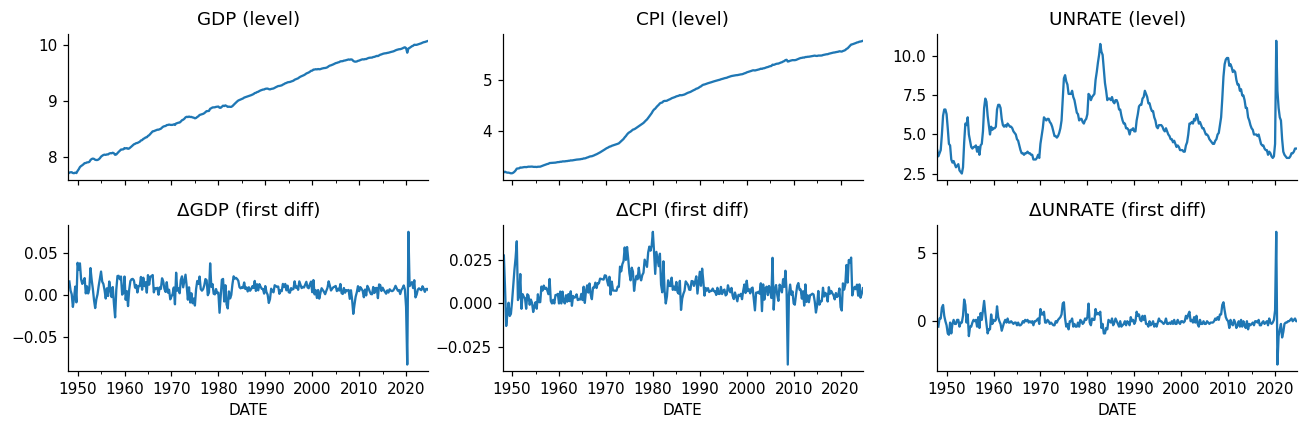

In [3]:
fig, axes = plt.subplots(2, 3, figsize=(12,4), sharex='col')
for ax, s in zip(axes[0], df.columns):
    df[s].plot(ax=ax)
    ax.set_title(f'{s} (level)')
for ax, s in zip(axes[1], df.columns):
    df[s].diff().plot(ax=ax)
    ax.set_title(f'Δ{s} (first diff)')
fig.tight_layout()


> **Checkpoint ✍️**  
> Which of these three series appears mean‐reverting (I(0)) versus trending (I(1))?


## 3 · Unit‐root workbench (ADF & KPSS)

- **ADF** null: unit root (I(1))  
- **KPSS** null: stationarity (I(0))  

Use the widgets to select series, lag length, and trend.


In [4]:
# @title 3 · Unit-root workbench (ADF & KPSS) — corrected {display-mode: "code"}
from arch.unitroot import ADF, KPSS

def unitroot_tests(series='GDP', maxlag=4, trend='c'):
    y = df[series].dropna()
    # ADF: uses maxlag
    adf = ADF(y, lags=maxlag, trend=trend)
    # KPSS: also uses maxlag
    kpss = KPSS(y, lags=maxlag, trend=trend)
    out = pd.DataFrame({
        'Test':       ['ADF',    'KPSS'],
        'Statistic':  [adf.stat, kpss.stat],
        'p-value':    [adf.pvalue, kpss.pvalue],
        'Lags used':  [adf.lags, kpss.lags]
    })
    display(out)

wd.interact(
    unitroot_tests,
    series=wd.Dropdown(options=df.columns, value='GDP', description='Series'),
    maxlag=wd.IntSlider(value=4, min=0, max=12, step=1, description='Max lag'),
    trend=wd.RadioButtons(
        options={'No trend':'n','Constant':'c','Const+trend':'ct'},
        value='c',
        description='Trend'
    )
);


interactive(children=(Dropdown(description='Series', options=('GDP', 'CPI', 'UNRATE'), value='GDP'), IntSlider…

## 4 · Structural‐break test (Zivot & Andrews)

One endogenous break in intercept, trend, or both chosen to minimize the ADF τ‐statistic.


ZA τ-stat   = -3.708
p-value      = 0.541
lags used    = 2
crit. values = {'1%': np.float64(-5.27644), '5%': np.float64(-4.81067), '10%': np.float64(-4.56618)}
break date   = 2007Q4


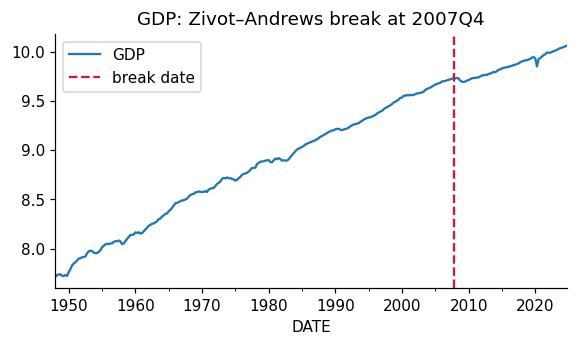

In [5]:
# @title 4 · Structural‐break test (Zivot & Andrews via statsmodels) {display-mode: "code"}
from statsmodels.tsa.stattools import zivot_andrews

series = 'GDP'  # ← change to 'CPI' or 'UNRATE' and re-run

# Run the test: returns (stat, pvalue, crit_vals, lags_used, break_index)
za_res = zivot_andrews(
    df[series],
    trim=0.15,      # ignore first/last 15% when searching breaks
    maxlag=8,       # maximum AR lags
    regression='c'  # model: constant only under the alternative
)
stat, pvalue, crit_vals, lags_used, break_idx = za_res

print(f"ZA τ-stat   = {stat:.3f}")
print(f"p-value      = {pvalue:.3f}")
print(f"lags used    = {lags_used}")
print(f"crit. values = {crit_vals}")
print(f"break date   = {df.index[break_idx]}")

# Plot the series with the detected break
ax = df[series].plot(
    figsize=(6,3),
    title=f"{series}: Zivot–Andrews break at {df.index[break_idx]}"
)
ax.axvline(
    df.index[break_idx].to_timestamp(),
    color='crimson', linestyle='--', label='break date'
)
ax.legend()
plt.show()


## 5 · How big is the random walk? — Persistence metrics


AR(1) φ = 0.129 → half‐life ≈ 0.3 quarters
ψ(1) ≈ 1.18
VR(40) = 1.214


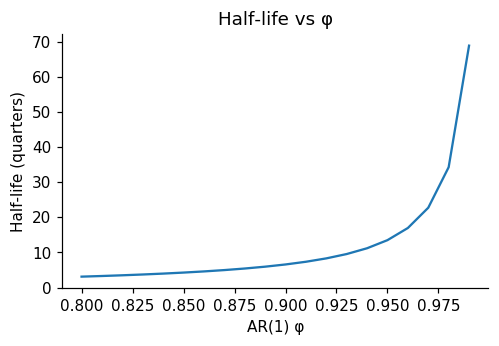

In [8]:
# @title 5 · Persistence metrics (fixed arma_impulse_response call) {display-mode: "code"}
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.arima_process import arma_impulse_response

# 5.1 — AR(1) half‐life on Δlog GDP
growth = df['GDP'].diff().dropna()
ar1_mod = sm.tsa.ARIMA(growth, order=(1,0,0)).fit()
phi = ar1_mod.arparams[0]
half_life = np.log(0.5) / np.log(abs(phi))
print(f"AR(1) φ = {phi:.3f} → half‐life ≈ {half_life:.1f} quarters")

# 5.2 — Long‐run multiplier ψ(1) from ARMA(4,2) on growth
arma_mod = sm.tsa.ARIMA(growth, order=(4,0,2)).fit()
ar_pol = np.r_[1, -arma_mod.arparams]    # [1, -φ1, -φ2, …]
ma_pol = np.r_[1,  arma_mod.maparams]    # [1, θ1, θ2, …]

# Call with positional “lags” argument, not nobs=
irfs = arma_impulse_response(ar_pol, ma_pol, 40)
psi1 = irfs.sum()
print(f"ψ(1) ≈ {psi1:.2f}")

# 5.3 — Variance‐ratio VR(40) on log‐GDP (manual)
k = 40
y = df['GDP']
num  = (y - y.shift(k)).dropna().var()
den  = k * y.diff().dropna().var()
vr40 = num / den
print(f"VR({k}) = {vr40:.3f}")

# Optional: plot half‐life vs φ
phis = np.linspace(0.8, 0.99, 20)
hl   = np.log(0.5) / np.log(np.abs(phis))
plt.figure(figsize=(5,3))
plt.plot(phis, hl)
plt.xlabel('AR(1) φ')
plt.ylabel('Half‐life (quarters)')
plt.title('Half‐life vs φ')
plt.show()


## 6 · Sticky‐price New‐Keynesian toy

Log‐linear NK model:
\[
\pi_t = \beta E_t[\pi_{t+1}] + \kappa \tilde y_t,\quad
\tilde y_t = E_t[\tilde y_{t+1}] - \sigma (i_t - E_t[\pi_{t+1}] - r^n_t)
\]
With a one‐time permanent TFP shock (ε₀ = 1), see why the output gap ̃y is I(0) even though potential y\* is I(1).


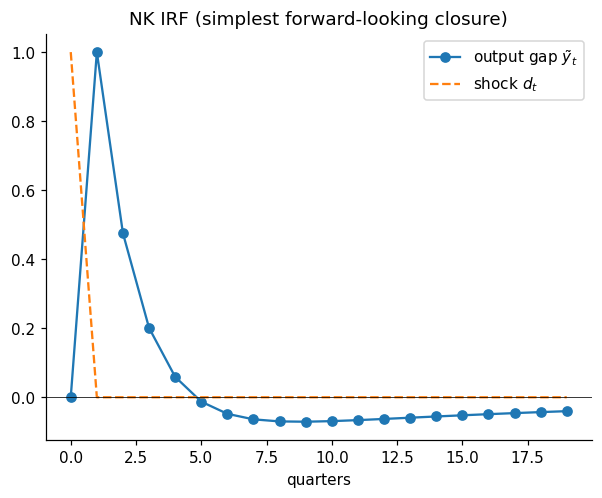

In [12]:
import numpy as np, matplotlib.pyplot as plt

beta  = 0.99
kappa = 0.05      # flatter Phillips curve
sigma = 1
phi_pi, phi_x = 1.5, 0.5

h = 20
rho = 0.5
d  = np.zeros(h); d[0]=1         # demand (IS) shock

gap = np.zeros(h)
pi  = np.zeros(h)
i   = np.zeros(h)

for t in range(h-1):
    # simple expectational closure: E_t[x_{t+1}] = gap[t], same for pi
    i[t]    = phi_pi*pi[t] + phi_x*gap[t]
    gap[t+1]= ( gap[t] - (i[t] - pi[t]) + d[t] ) / sigma
    pi[t+1] = beta*pi[t] + kappa*gap[t+1]

plt.plot(gap, 'o-', label=r'output gap $\tilde y_t$')
plt.plot(d, '--', label=r'shock $d_t$')
plt.axhline(0,color='k',lw=.5)
plt.title('NK IRF (simplest forward-looking closure)')
plt.xlabel('quarters'); plt.legend(); plt.show()
